In [28]:
%pylab inline
import numpy as np
import seaborn as sns
sns.set(style="white", color_codes=True, font_scale=1.5)

Populating the interactive namespace from numpy and matplotlib


# Worm-like chain model
Force-extension curves obtained from AFM experiments are often fitted to this simple polymer model, which is approximated as follows


$F(x)=\frac{k_BT}{p}\bigg(\frac{1}{4(1-x/L)^2}+\frac{1}{4}-\frac{x}{L}\bigg)$


In this expression we find that the force $F$ at polymer extension $x$ can be expressed in terms of the persistence length $p$ and the contour length $L$. 

In [29]:
def wlc_force(x, p, L):
    #kBT = 8.314e-3*300 # kJ/mol
    kBT = 1.381e-23*300 # J
    invL = 1./L # nm^-1
    #p = 0.39
    return kBT/p*(1./(4*(1-x*invL)**2) - 1./4 + x*invL)*1e21 # pN

The figure below shows how the model reproduces a typical force-extension pattern.

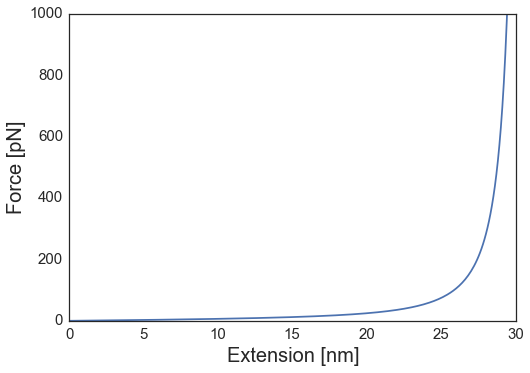

In [30]:
fig, ax = plt.subplots()
x = np.arange(0,30,0.1)
ax.plot(x, wlc_force(x, 0.4, 31))
ax.set_ylim(0,1000)
ax.set_xlabel('Extension [nm]', size=20)
_ = ax.set_ylabel('Force [pN]', size=20)

Next we load a characteristic sawtooth trace from an experiment on titin. We compare it with the results from the WLC model with manually defined parameters.

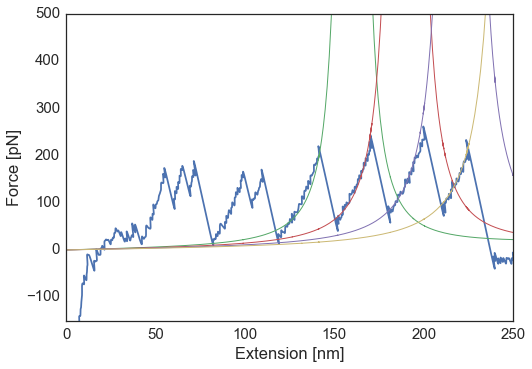

In [31]:
force_extension = np.array([(float(x.split()[0]), float(x.split()[1])) \
                   for x in open('HumanGoodTrace.txt', 'r').readlines()])
#force_extension = force_extension[650:1400]
fig, ax = plt.subplots()
ax.plot(force_extension[0:,0], force_extension[:,1])
for l in [160, 190, 221, 253]:
    ax.plot(force_extension[0:,0], wlc_force(force_extension[:,0], 0.4, l), linewidth=1)
ax.set_xlim(0,250)
ax.set_ylim(-150,500)
#ax.set_ylim(10,400)
#ax.set_yscale('log')
ax.set_xlabel('Extension [nm]')
_ = ax.set_ylabel('Force [pN]')

Next we try to identify the peaks in the trace, so that the fitting can be done automatically. I try three different libraries for finding peaks. Of the tree, probably the least satisfying is the `scipy` built-in, called `find_peaks_cwt`. `detect_peaks` works well, but it finds two peaks too many. Finally `peakdetect` does a great job, and as a bonus it returns the valleys.

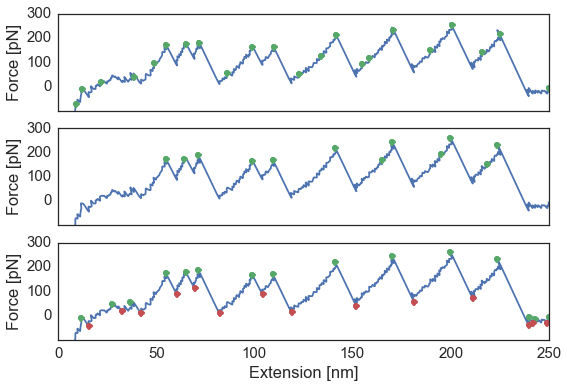

In [32]:
from scipy import signal

fig, ax = plt.subplots(3,1, sharex=True)
peakind = signal.find_peaks_cwt(force_extension[:,1], np.arange(1,100), min_length=30)
ax[0].plot(force_extension[0:,0], force_extension[:,1])
ax[0].plot(force_extension[peakind,0], force_extension[peakind,1], 'o')
ax[0].set_xlim(0,250)
ax[0].set_yticks(range(0,310,100))
ax[0].set_ylim(-100,300)
ax[0].set_ylabel('Force [pN]')

import detect_peaks
indexes = detect_peaks.detect_peaks(force_extension[:,1], mph=150, mpd=100)
ax[1].plot(force_extension[0:,0], force_extension[:,1])
ax[1].plot(force_extension[indexes,0], force_extension[indexes,1], 'o')
ax[1].set_xlim(0,250)
ax[1].set_yticks(range(0,310,100))
ax[1].set_ylim(-100,300)
ax[1].set_ylabel('Force [pN]')

from peakdetect import peakdetect
ax[2].plot(force_extension[0:,0], force_extension[:,1])
peaks_valleys = peakdetect(force_extension[:,1], lookahead=50)
indexes = [x[0] for x in peaks_valleys[0]]
ax[2].plot(force_extension[indexes,0], force_extension[indexes,1], 'o')
indexes = [x[0] for x in peaks_valleys[1]]
ax[2].plot(force_extension[indexes,0], force_extension[indexes,1], 'o')
ax[2].set_xlim(0,250)
ax[2].set_ylim(-100,300)
ax[2].set_yticks(range(0,310,100))

ax[2].set_xlabel('Extension [nm]')
ax[2].set_ylabel('Force [pN]')
_ = plt.tight_layout()

So we can define the datasets to fit using peaks and valleys.

In [33]:
datasets = []
peaks, valleys = peaks_valleys

for p in peaks:
    # find closest valley
    try: 
        v = [x for x in valleys if x[0]<p[0]][-1]
        
        if (p[1] - v[1] > 50) and (v[1] > 0):
            print "Peaks:", force_extension[p[0],0], p[1]
            print "Valley: ", force_extension[v[0],0], v[1]
            print ""
            datasets.append(force_extension[v[0]:p[0]]) 
    except IndexError:
        pass

Peaks: 54.7729 173.462
Valley:  42.1621 11.9268

Peaks: 64.9332 177.907
Valley:  60.5982 86.6115

Peaks: 71.3377 188.172
Valley:  69.5313 113.708

Peaks: 98.8782 165.692
Valley:  82.2885 9.66619

Peaks: 109.286 170.005
Valley:  104.154 88.9772

Peaks: 141.077 219.689
Valley:  118.99 13.0229

Peaks: 170.169 243.896
Valley:  152.012 40.0068

Peaks: 199.863 261.421
Valley:  181.383 57.5789

Peaks: 223.814 232.826
Valley:  211.327 71.9571



In [34]:
import inspect
from scipy.optimize import curve_fit

class Fit():
    def __init__(self, formula, x, y, p0=None, error=None):
        self.formula = formula
        print " fitting data to %s"%formula.__name__
        self.create_params(p0)
        print "     initial parameters:",self.p0
        self.fit_function(x,y, error=error)
        print "     fitted parameters:",self.popt
        print "     fitting errors:",np.sqrt(np.diag(self.pcov))
        #self.calc_r2(y,self.formula(x,*self.popt))
        #print "     R**2: %g "%self.r2
        print ""

    def __call__(self,t):
        return self.formula(t,*self.popt)

    def create_params(self,p0=None):
        """ create parameters """
        # define number of parameters
        self.nparams = len(inspect.getargspec(self.formula)[0]) - 1
        print "      number of parameters: %g"%self.nparams
        # check for user defined initial parameters
        if not p0:
            self.p0 = np.random.random(self.nparams)
        else:
            if len(p0) != self.nparams:
                print " Wrong number of initial parameters",len(p0)
                print "          %g required"%self.nparams
                sys.exit(1)
            self.p0 = p0

    def fit_function(self,x,y,p0=None,error=None):
        """ fit the data to the chosen functional form """
        popt, pcov = curve_fit(self.formula, x, y, p0=self.p0, sigma=error, maxfev = self.nparams*1000000)
        self.popt = popt
        self.pcov = pcov

    def calc_r2(self,y,ycalc):
        """ define goodness of fit metric """
        sse = np.sum((y-ycalc)**2)
        sst = np.sum((y-np.mean(y))**2)
        self.r2 = 1 - (sse/sst)*(len(y)-1)/(len(y)-self.nparams)

 fitting data to wlc_force
      number of parameters: 2
     initial parameters: [0.4, 60.23237000000001]
     fitted parameters: [  0.25202121  65.25607222]
     fitting errors: [ 0.00811635  0.26396779]

 fitting data to wlc_force
      number of parameters: 2
     initial parameters: [0.4, 71.341160000000002]
     fitted parameters: [  0.18355398  79.50856637]
     fitting errors: [ 0.00805886  0.48718874]

 fitting data to wlc_force
      number of parameters: 2
     initial parameters: [0.4, 78.38479000000001]
     fitted parameters: [  0.15306089  90.85550365]
     fitting errors: [ 0.01846497  1.68791653]

 fitting data to wlc_force
      number of parameters: 2
     initial parameters: [0.4, 108.73753000000001]
     fitted parameters: [   0.43663051  112.37517827]
     fitting errors: [ 0.01226201  0.28122303]

 fitting data to wlc_force
      number of parameters: 2
     initial parameters: [0.4, 120.12990000000001]
     fitted parameters: [   0.24093088  132.71295493]
     f

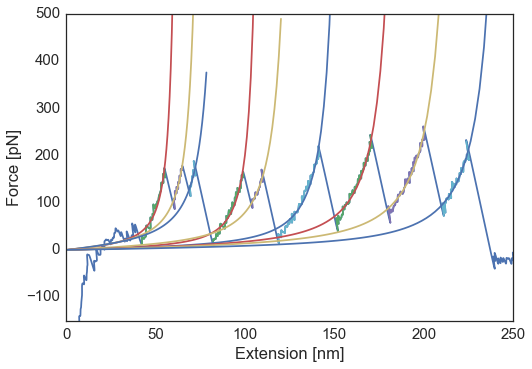

In [37]:
fig, ax = plt.subplots()
ax.plot(force_extension[0:,0], force_extension[:,1])
for ds in datasets:
    fitwlc = Fit(wlc_force, ds[:,0], ds[:,1], p0 = [0.4, ds[-1,0]*1.1])
    x = np.arange(0,ds[-1,0]*1.1,100)
    ax.plot(ds[:,0], ds[:,1])
    x = np.linspace(0,ds[-1,0]*1.1,100)
    _ = ax.plot(x, fitwlc(x))
ax.set_xlim(0,250)
ax.set_ylim(-150,500)
#ax.set_ylim(10,400)
#ax.set_yscale('log')
ax.set_xlabel('Extension [nm]')
_ = ax.set_ylabel('Force [pN]')

Next we load a characteristic sawtooth pattern from an MD simulation trajectory that we will fit to the worm-like chain model.